Monitoramento e Fairness

In [37]:
import pandas as pd
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

Carregar modelo e vetor já treinados

In [38]:
modelo_path = "../model.joblib"
vetor_path = "../vectorizer.joblib"
dados_path = "../data/tweets_limpo.csv"

if not (os.path.exists(modelo_path) and os.path.exists(vetor_path)):
    raise FileExistsError("Treine e salve o modelo antes de executar")

model = joblib.load(modelo_path)
vectorizer = joblib.load(vetor_path)
df = pd.read_csv(dados_path)
display(df.head())



,text,label,text_length
0,Adorei o produto de investimentos no mercado d...,positivo,56
1,O serviço de instalação internet foi péssimo. ...,negativo,59
2,Tudo dentro do esperado,neutro,23
3,Foi ok,neutro,6
4,Serviço horrível,negativo,16


Monitoramento

In [39]:
novos_textos = [
    'Muito ruim, não gostei do atendimento.',
    'A entrega foi sensacional.',
    'Não funcionou, me decepcionei.',
    'Recomendo para todos, nota 10! Top',
    'Recomendo para todos Top',
]

novos_df = pd.DataFrame({f'text': novos_textos})
display(novos_df)



,text
0,"Muito ruim, não gostei do atendimento."
1,A entrega foi sensacional.
2,"Não funcionou, me decepcionei."
3,"Recomendo para todos, nota 10! Top"
4,Recomendo para todos Top


Vetorizar e predição

In [40]:
novos_vetores = vectorizer.transform(novos_df["text"])
novos_preds = model.predict(novos_vetores)
novos_df['sentimento_predito'] = novos_preds
print(novos_df)

                                     text sentimento_predito
0  Muito ruim, não gostei do atendimento.           positivo
1              A entrega foi sensacional.           negativo
2          Não funcionou, me decepcionei.             neutro
3      Recomendo para todos, nota 10! Top           positivo
4                Recomendo para todos Top           negativo


Porcentagem de cada classe

In [41]:
class_dist = novos_df['sentimento_predito'].value_counts(normalize=True)
print('Distribuição dos sentimentos preditos nos novos dados:')
print(class_dist)

Distribuição dos sentimentos preditos nos novos dados:
sentimento_predito
positivo    0.4
negativo    0.4
neutro      0.2
Name: proportion, dtype: float64


Fairness - Vieses

In [42]:
df['text_len'] = df['text'].apply(len)
df['len_category'] = pd.cut(df['text_len'], bins=[0,50,150,1000], labels=['curto','medio','longo'])

display(df['len_category'])

0     medio
1     medio
2     curto
3     curto
4     curto
5     curto
6     curto
7     curto
8     curto
9     curto
10    curto
11    curto
12    curto
13    curto
14    curto
15    curto
16    curto
17    curto
18    curto
19    curto
20    curto
21    curto
22    curto
23    curto
24    curto
25    curto
26    curto
27    curto
28    curto
29    longo
30    longo
31    longo
32    longo
33    longo
34    longo
Name: len_category, dtype: category
Categories (3, object): ['curto' < 'medio' < 'longo']

Predições conjunto de validação

In [43]:
vetores = vectorizer.transform(df['text'])
df['pred'] = model.predict(vetores)
display(df['pred'])

0     positivo
1     negativo
2       neutro
3       neutro
4     negativo
5     negativo
6     positivo
7     negativo
8     positivo
9     negativo
10    positivo
11    negativo
12    positivo
13      neutro
14    positivo
15    negativo
16    positivo
17    positivo
18    positivo
19    negativo
20      neutro
21      neutro
22      neutro
23      neutro
24      neutro
25      neutro
26      neutro
27      neutro
28      neutro
29    positivo
30    negativo
31      neutro
32    negativo
33      neutro
34    positivo
Name: pred, dtype: object

Avaliação de acurácia

In [44]:
for cat in df['len_category'].unique():
    subset = df[df['len_category']== cat]
    if not subset.empty:
        acuracia = (subset['label'] == subset['pred']).mean()
        print(f'Acuracia para os textos {cat}: {acuracia:.2f} N={len(subset)}')

Acuracia para os textos medio: 1.00 N=2
Acuracia para os textos curto: 0.96 N=27
Acuracia para os textos longo: 1.00 N=6


Desafio fairness

Matriz de confusão para textos medio:
[[1 0]
 [0 1]]


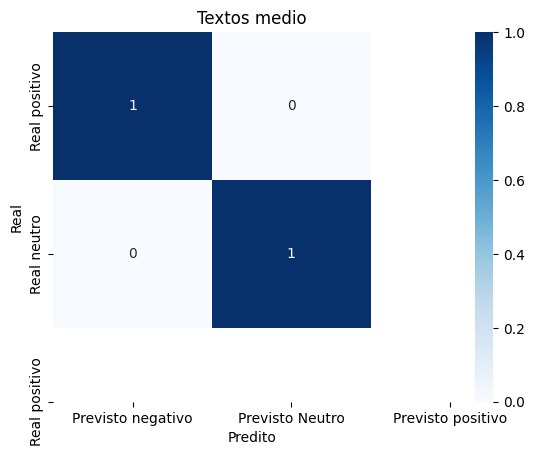

Matriz de confusão para textos curto:
[[ 7  1  0]
 [ 0 11  0]
 [ 0  0  8]]


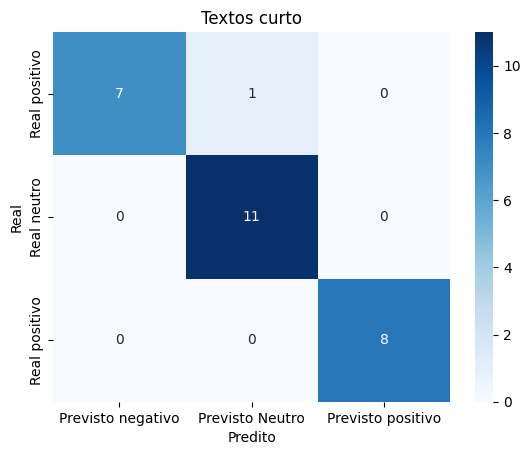

Matriz de confusão para textos longo:
[[2 0 0]
 [0 2 0]
 [0 0 2]]


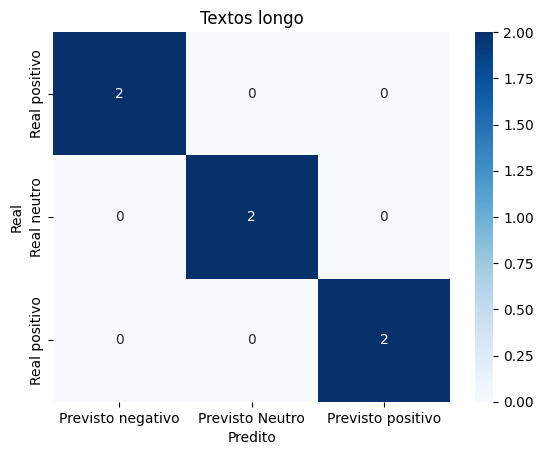

In [45]:
for cat in df['len_category'].unique():
    subset = df[df['len_category'] == cat]
    if not subset.empty:
        print(f'Matriz de confusão para textos {cat}:')
        print(confusion_matrix(subset['label'], subset["pred"]))
        sns.heatmap(confusion_matrix(subset['label'], subset["pred"]),
                    annot=True, fmt='d', cmap="Blues",
                    xticklabels=['Previsto negativo','Previsto Neutro','Previsto positivo'],
                    yticklabels=['Real positivo','Real neutro','Real positivo'])
        plt.title(f'Textos {cat}')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.show()
